In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series

## Simple forecasting methods to use as baseline

- Prepare the dataset: US change

In [2]:
us_change = pd.read_csv("data/us_change.csv")
forecast_steps = 8

data = us_change["Consumption"][:-forecast_steps]
quarters = us_change["Quarter"]
step = 20 
quarter_labels = quarters[::step]
covariables = us_change[["Income", "Production", "Savings", "Unemployment"]][:-forecast_steps]

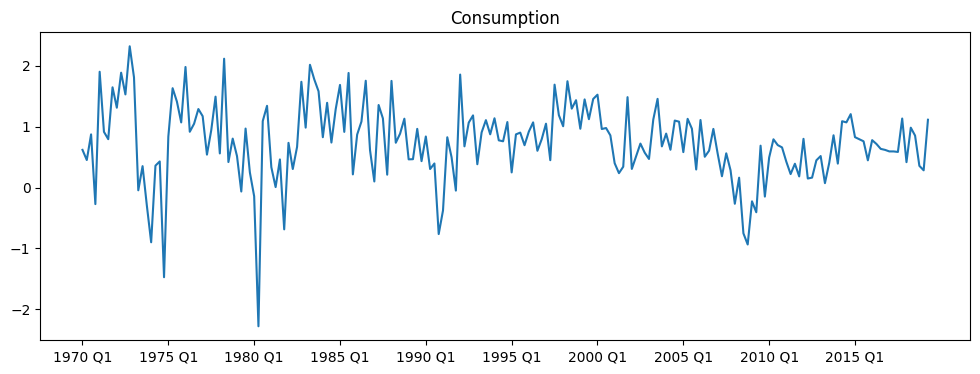

In [3]:
plt.figure(figsize=(12,4))
plt.title("Consumption")
plt.plot(us_change["Quarter"], us_change["Consumption"])
plt.xticks(ticks=quarter_labels)
plt.show()

In [4]:
def plot_forecast(model, y, steps_ahead=8):
    fh = ForecastingHorizon([i+1 for i in range(steps_ahead)], is_relative=True)
    y_pred = model.predict(fh)

    pred_ints = model.predict_interval(coverage=0.95)

    plot_series(y, y_pred, labels=["Actual", "Forecast"], pred_interval=pred_ints,
                colors = ["black", "blue"], markers=[",", ","])
    plt.legend()
    plt.show()

In [5]:
def forecast(model, y, steps_ahead=8):
    fh = ForecastingHorizon([i+1 for i in range(steps_ahead)], is_relative=True)
    y_pred = model.predict(fh)
    return y_pred

### Mean method

In [6]:
mean_model = NaiveForecaster(strategy='mean')
mean_model.fit(y=data)

NaiveForecaster(strategy='mean')

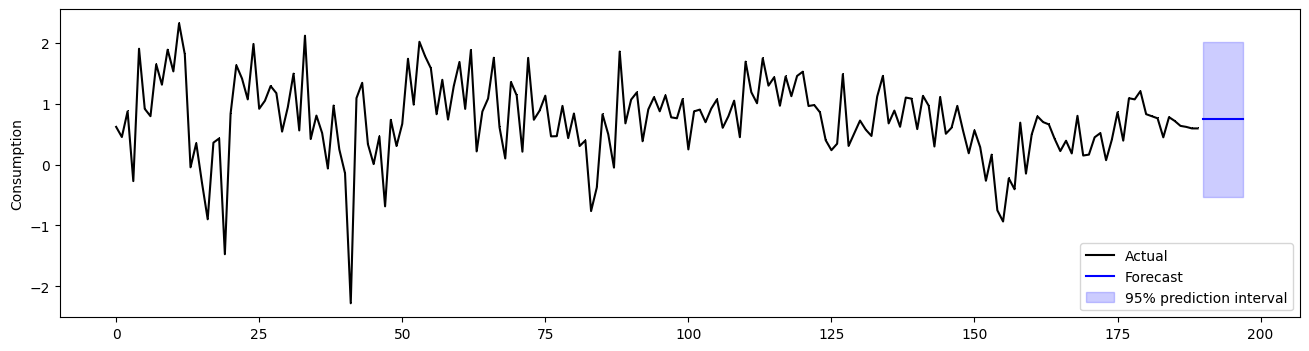

In [7]:
plot_forecast(mean_model, data)

- Residual Analysis

c:\Users\Ramyro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sktime\forecasting\base\_base.py:1242: UserWarning: empty y passed to update_predict of NaiveForecaster(strategy='mean'), no update was carried out
  warn(


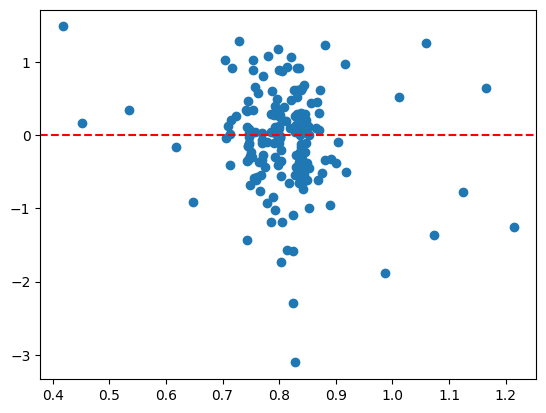

In [8]:
fh_in_sample = ForecastingHorizon(data.index, is_relative=False)
fitted_values_mean = mean_model.predict(fh_in_sample)
residuals_mean = data - fitted_values_mean

# Scatter plot: residuals vs fitted values
plt.scatter(fitted_values_mean, residuals_mean)
plt.axhline(0, color="red", linestyle="--")
plt.show()

In [9]:
# Teste de Ljung-Box
ljung_box_results = acorr_ljungbox(residuals_mean, lags=[10], return_df=True)
print(ljung_box_results)

      lb_stat     lb_pvalue
10  70.845081  3.044314e-11


- Due to a low $p-$value, the residues show a large correlation.

In [10]:
# MAE
mae = mean_absolute_error(data, fitted_values_mean)

# MSE
mse = mean_squared_error(data, fitted_values_mean)

# RMSE
rmse = np.sqrt(mse)

#MAPE
mape = np.mean(np.abs((data - fitted_values_mean) / data)) * 100

# R²
r2 = r2_score(data, fitted_values_mean)

print(f"MAE: {mae}", f"MSE: {mse}", f"RMSE: {rmse}", 
      f"MAPE: {mape}%", f"R²: {r2}",
      sep="\n")

MAE: 0.4791363337469884
MSE: 0.43261230783920085
RMSE: 0.6577327024249295
MAPE: 174.8446884945578%
R²: -0.03650411734211789


In [11]:
forecast_mean = forecast(mean_model, data)
real_values = us_change["Consumption"][-forecast_steps:]

# Avaliação das previsões fora da amostra
mae_outsample = mean_absolute_error(real_values, forecast_mean)
mse_outsample = mean_squared_error(real_values, forecast_mean)
print(f"Out-of-sample MAE: {mae_outsample}, MSE: {mse_outsample}")

Out-of-sample MAE: 0.3052321492711174, MSE: 0.10649876273941161


### Naive method

In [12]:
naive_model = NaiveForecaster(strategy='last')
naive_model.fit(y=data)

NaiveForecaster()

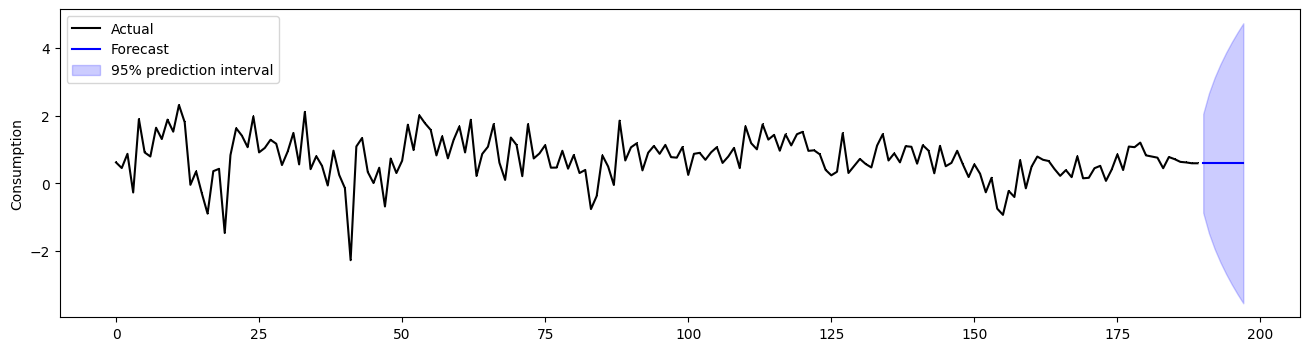

In [13]:
plot_forecast(naive_model, data)

- Residual Analysis

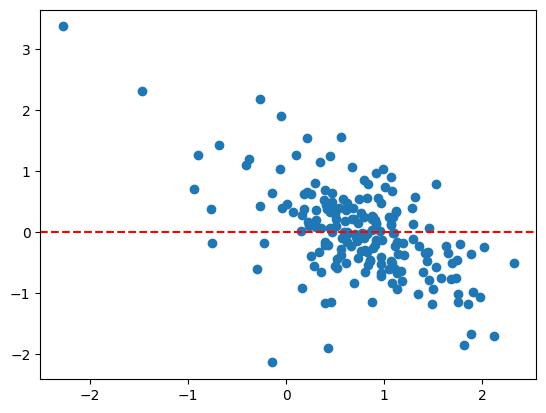

In [14]:
fh_in_sample = ForecastingHorizon(data.index, is_relative=False)
fitted_values_naive = naive_model.predict(fh_in_sample)
residuals_naive = data - fitted_values_naive

# Scatter plot: residuals vs fitted values
plt.scatter(fitted_values_naive, residuals_naive)
plt.axhline(0, color="red", linestyle="--")
plt.show()

In [15]:
# Teste de Ljung-Box
ljung_box_results = acorr_ljungbox(residuals_naive, lags=[10], return_df=True)
print(ljung_box_results)

      lb_stat     lb_pvalue
10  58.730495  6.296163e-09


- Due to a low $p-$value, the residues show a large correlation.

In [16]:
# MAE
mae = mean_absolute_error(data, fitted_values_naive)

# MSE
mse = mean_squared_error(data, fitted_values_naive)

# RMSE
rmse = np.sqrt(mse)

#MAPE
mape = np.mean(np.abs((data - fitted_values_naive) / data)) * 100

# R²
r2 = r2_score(data, fitted_values_naive)

print(f"MAE: {mae}", f"MSE: {mse}", f"RMSE: {rmse}", 
      f"MAPE: {mape}%", f"R²: {r2}",
      sep="\n")

MAE: 0.5539666901465785
MSE: 0.5567634844260348
RMSE: 0.7461658558430792
MAPE: 147.78508862930101%
R²: -0.3339603001027627


In [17]:
forecast_naive = forecast(naive_model, data)
real_values = us_change["Consumption"][-forecast_steps:]

# Avaliação das previsões fora da amostra
mae_outsample = mean_absolute_error(real_values, forecast_naive)
mse_outsample = mean_squared_error(real_values, forecast_naive)
print(f"Out-of-sample MAE: {mae_outsample}, MSE: {mse_outsample}")

Out-of-sample MAE: 0.3052321492711174, MSE: 0.12067886382054763


### Seasonal naive method

In [18]:
snaive_model = NaiveForecaster(strategy='last', sp=4)
snaive_model.fit(y=data)

NaiveForecaster(sp=4)

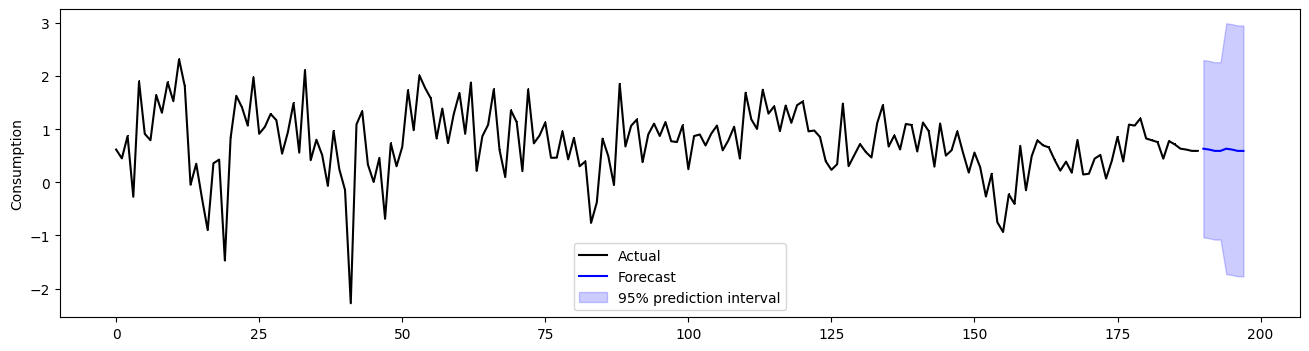

In [19]:
plot_forecast(snaive_model, data)

- Residual Analysis

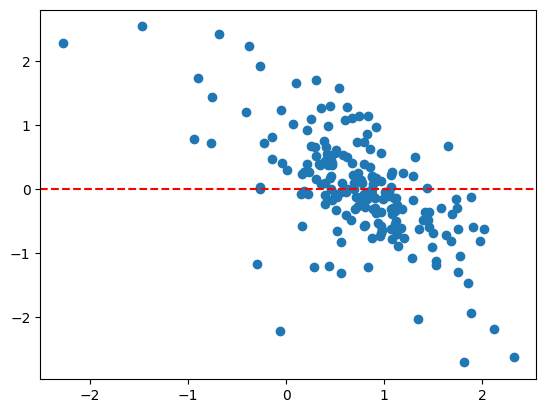

In [20]:
fh_in_sample = ForecastingHorizon(data.index, is_relative=False)
fitted_values_snaive = snaive_model.predict(fh_in_sample)
residuals_snaive = data - fitted_values_snaive

# Scatter plot: residuals vs fitted values
plt.scatter(fitted_values_snaive, residuals_snaive)
plt.axhline(0, color="red", linestyle="--")
plt.show()

In [21]:
# Teste de Ljung-Box
ljung_box_results = acorr_ljungbox(residuals_snaive, lags=[10], return_df=True)
print(ljung_box_results)

      lb_stat     lb_pvalue
10  55.931967  2.114032e-08


- Due to a low $p-$value, the residues show a large correlation.

In [22]:
# MAE
mae = mean_absolute_error(data, fitted_values_snaive)

# MSE
mse = mean_squared_error(data, fitted_values_snaive)

# RMSE
rmse = np.sqrt(mse)

#MAPE
mape = np.mean(np.abs((data - fitted_values_snaive) / data)) * 100

# R²
r2 = r2_score(data, fitted_values_snaive)

print(f"MAE: {mae}", f"MSE: {mse}", f"RMSE: {rmse}", 
      f"MAPE: {mape}%", f"R²: {r2}",
      sep="\n")

MAE: 0.6208000796425139
MSE: 0.7113998175305374
RMSE: 0.8434452071892622
MAPE: 306.15692030574604%
R²: -0.7044564534694386


In [23]:
forecast_snaive = forecast(snaive_model, data)
real_values = us_change["Consumption"][-forecast_steps:]

# Avaliação das previsões fora da amostra
mae_outsample = mean_absolute_error(real_values, forecast_snaive)
mse_outsample = mean_squared_error(real_values, forecast_snaive)
print(f"Out-of-sample MAE: {mae_outsample}, MSE: {mse_outsample}")

Out-of-sample MAE: 0.3052779229031577, MSE: 0.11674571114482665


### Drift method

In [24]:
drift_model = NaiveForecaster(strategy='drift')
drift_model_fit = drift_model.fit(y=data)

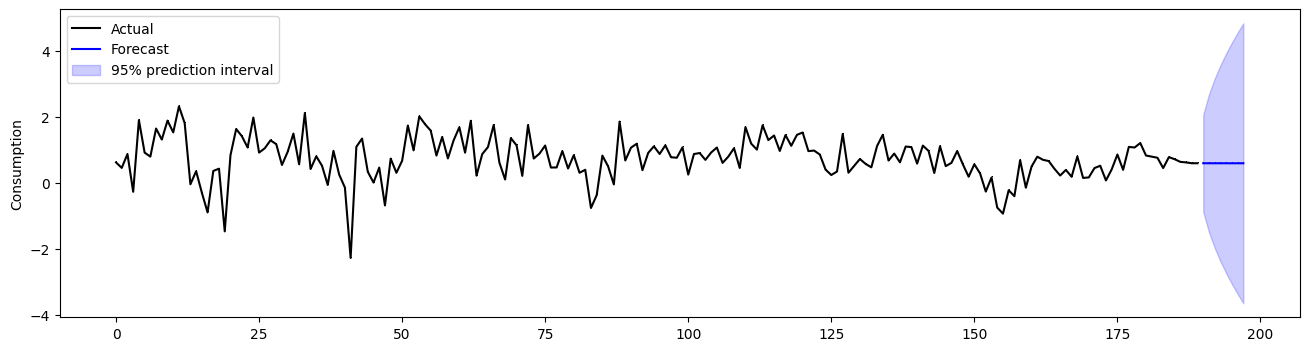

In [25]:
plot_forecast(drift_model, data)

- Residual analysis

c:\Users\Ramyro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sktime\forecasting\base\_base.py:1242: UserWarning: empty y passed to update_predict of NaiveForecaster(strategy='drift'), no update was carried out
  warn(


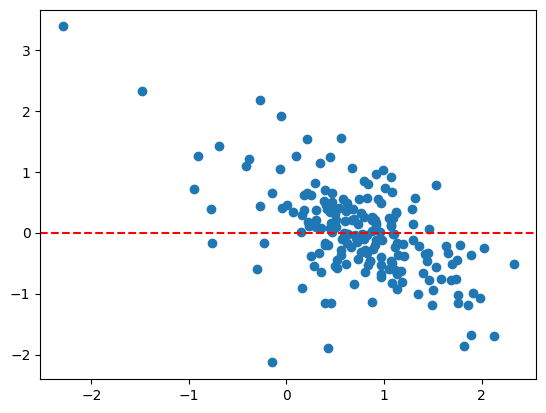

In [26]:
fh_in_sample = ForecastingHorizon(data.index, is_relative=False)
fitted_values_drift = drift_model.predict(fh_in_sample)
residuals_drift = data - fitted_values_drift

# Scatter plot: residuals vs fitted values
plt.scatter(fitted_values_drift, residuals_drift)
plt.axhline(0, color="red", linestyle="--")
plt.show()

In [27]:
# Teste de Ljung-Box
ljung_box_results = acorr_ljungbox(residuals_drift, lags=[10], return_df=True)
print(ljung_box_results)

      lb_stat     lb_pvalue
10  58.553157  6.800202e-09


- Due to a low $p-$value, the residues show a large correlation.

In [28]:
# MAE
mae = mean_absolute_error(data, fitted_values_drift)

# MSE
mse = mean_squared_error(data, fitted_values_drift)

# RMSE
rmse = np.sqrt(mse)

#MAPE
mape = np.mean(np.abs((data - fitted_values_drift) / data)) * 100

# R²
r2 = r2_score(data, fitted_values_drift)

print(f"MAE: {mae}", f"MSE: {mse}", f"RMSE: {rmse}", 
      f"MAPE: {mape}%", f"R²: {r2}",
      sep="\n")

MAE: 0.5563091257540884
MSE: 0.5598674780053173
RMSE: 0.7482429271335062
MAPE: 148.1506610565793%
R²: -0.3413972177928757


In [29]:
forecast_drift = forecast(drift_model, data)
real_values = us_change["Consumption"][-forecast_steps:]

# Avaliação das previsões fora da amostra
mae_outsample = mean_absolute_error(real_values, forecast_drift)
mse_outsample = mean_squared_error(real_values, forecast_drift)
print(f"Out-of-sample MAE: {mae_outsample}, MSE: {mse_outsample}")

Out-of-sample MAE: 0.30526576434101216, MSE: 0.1208129163062875
